## Описание 

В этом эксперименте я попытался изменить просто кросс-энтропия на взвешенную кросс-энтропию из соображений, что в датасете есть фотографии, где человек занимает очень малую часть изображения, и есть фотографии, где ситуация противоположная. Итоговый результат не улучшился в обоих случаях

In [2]:
DATA_DIR = '/data/vapyzh/data'

In [3]:
ls $DATA_DIR

pred_valid_template.csv  test/  train/  train_mask/  valid/  valid_mask/


In [4]:
pip install torchsummary

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Напишем датасет

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess
import cv2

import torch
import torchvision.transforms as transforms

from collections import defaultdict
from tqdm.notebook import tqdm
import time
from IPython.display import clear_output

from torch import nn
from torchsummary import summary

from PIL import Image
from torch.utils.data import Dataset, random_split
from lib import *

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [6]:
class SegmentationDataset(Dataset):
    def __init__(self, data_path, mask_path, transform):
        """
        Args:
            data_path: путь до изображений.
            mask_path: путь до масок изображений.
            transform: трансформация для изображений.
        """
        self.data_path = data_path
        self.mask_path = mask_path
        self.transform = transform

        self.file_list = os.listdir(self.data_path)
        self.mask_list = os.listdir(self.mask_path)

        #Теперь отсортируем их, чтобы получить соответсвие.

        self.file_list.sort()
        self.mask_list.sort()

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        image_filename = self.file_list[idx]
        mask_filename = self.mask_list[idx]
        
        image = cv2.imread(os.path.join(self.data_path, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
        mask = cv2.imread(os.path.join(self.mask_path, mask_filename))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        transformed = self.transform(image=image, mask=mask)
        image = transformed["image"]
        mask = transformed["mask"][:,:,0]
        mask[mask != 0] = 1

        return transformed["image"], mask

In [7]:
train_transformer = A.Compose(
    transforms = [
                  A.HorizontalFlip(p=0.5),
                  A.CoarseDropout(max_holes=2, max_height=26, max_width=26,
                                  min_height=20, min_width=20, mask_fill_value=0, p=0.3),
                  A.Perspective(scale=(0.05, 0.1), p=0.3),
                  A.RandomScale(scale_limit=0.1, p=0.3),
                  A.Rotate(limit=20, p=0.3, border_mode= cv2.BORDER_CONSTANT),
                  A.Resize(240, 320),
                  ToTensorV2(),
                  ],
)

validation_transformer = A.Compose(
    transforms = [
                  A.Resize(240, 320),
                  ToTensorV2(),
                  ],
)

In [8]:
dataset = SegmentationDataset(DATA_DIR + '/train', DATA_DIR + '/train_mask', transform=train_transformer)

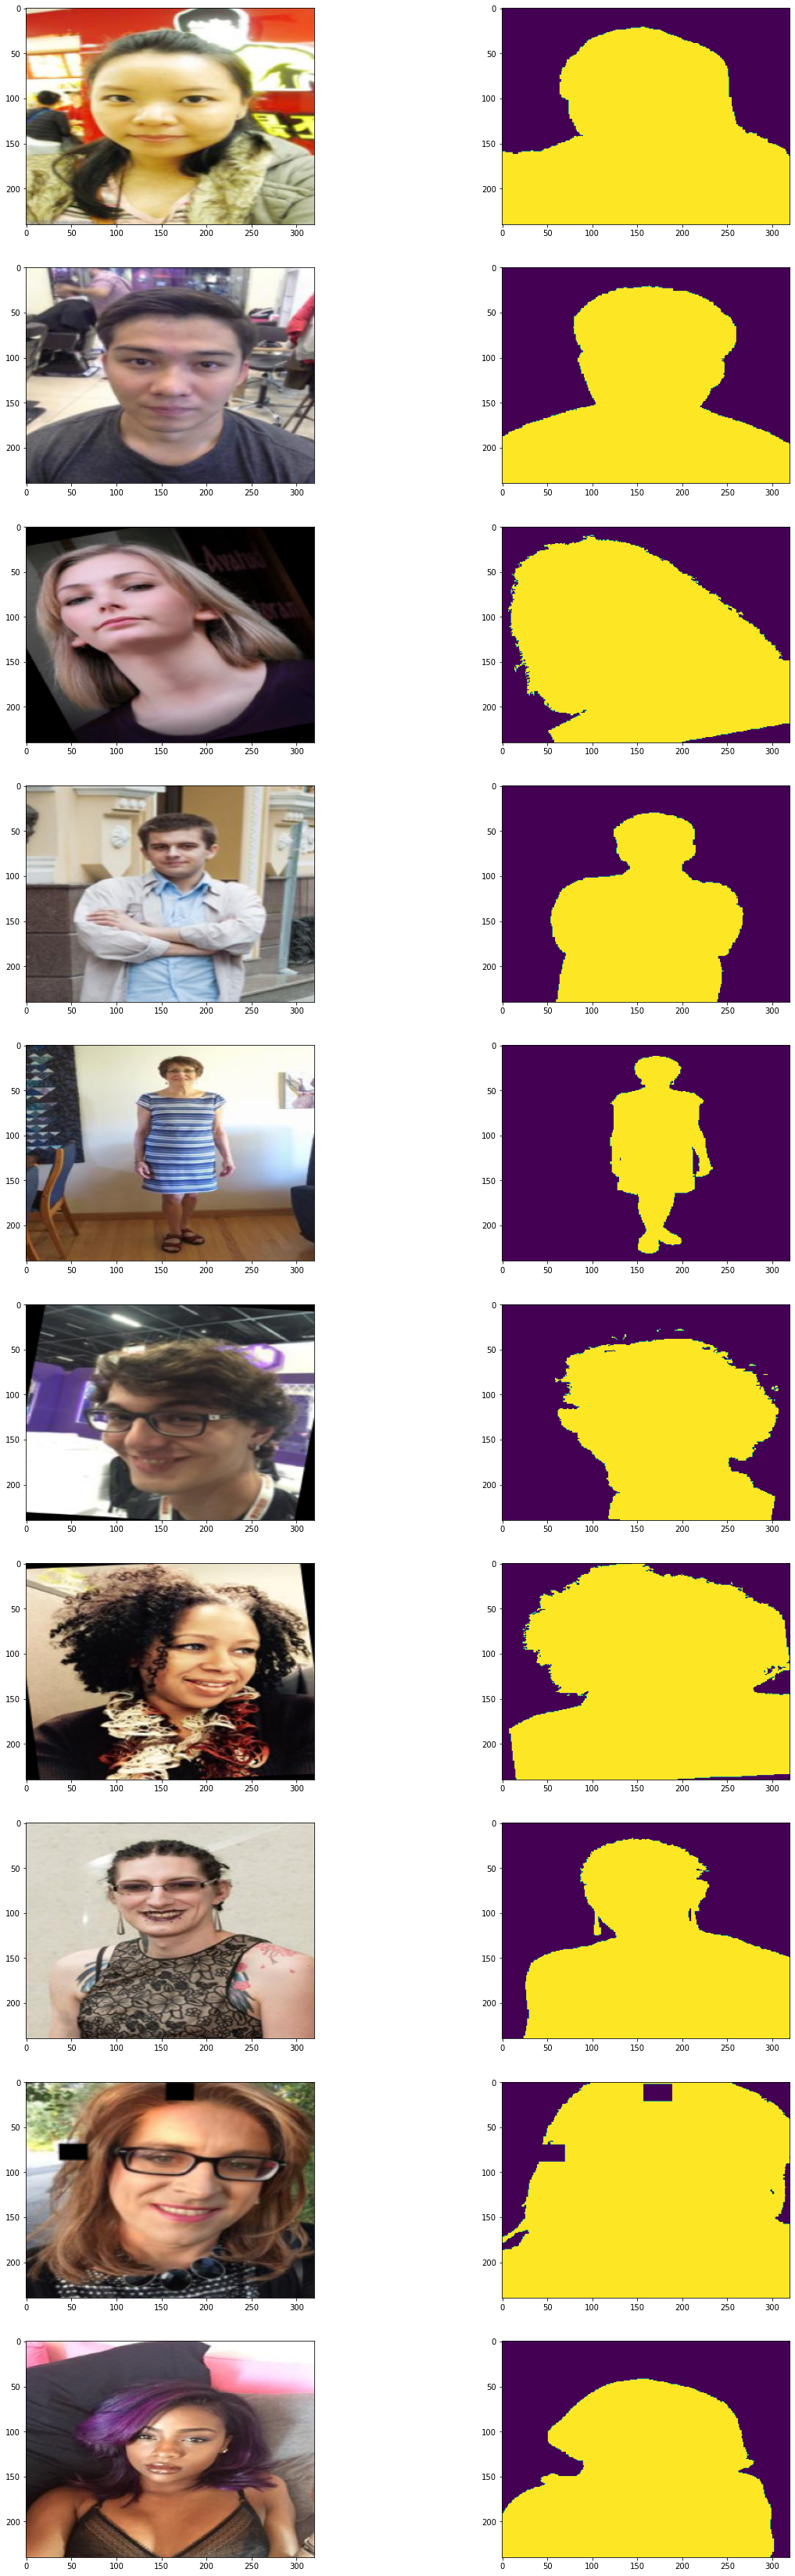

In [9]:
plt.figure(figsize=(20, 60))
for i in range(10):
    img, msk = dataset[i]
    plt.subplot(10, 2, i * 2 + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.subplot(10, 2, i * 2 + 2)
    plt.imshow(msk.squeeze())
plt.show()

In [10]:
pred = dataset[0][1]
true = dataset[1][1]

In [11]:
intersection = (pred * true)
sumset = pred  + true

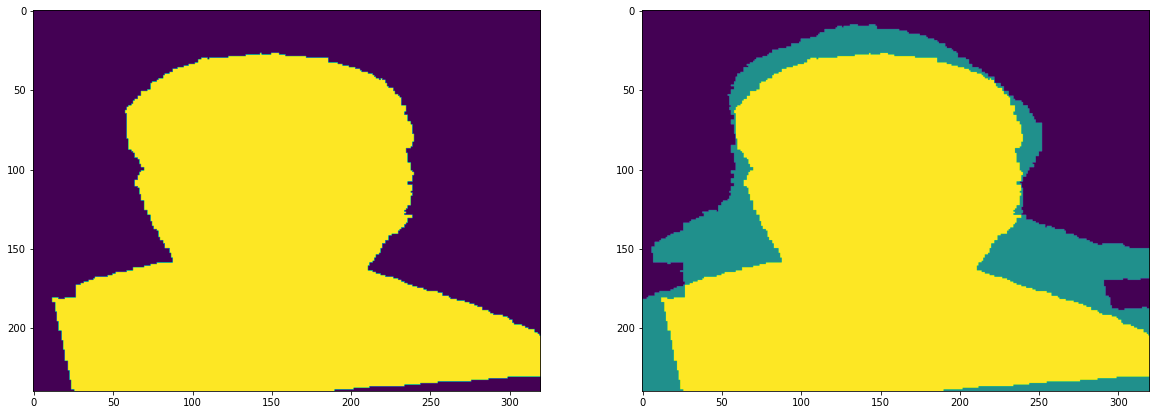

In [12]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(intersection)
plt.subplot(1, 2, 2)
plt.imshow(sumset)

plt.show()

In [13]:
loss = 1 - 2 * torch.sum(intersection) / torch.sum(sumset)

In [14]:
loss

tensor(0.1224)

In [15]:
def dice_loss(pred, true):
    # bs * x * y
    
    batch_size = pred.size(0)
    pred_flatten = pred.view(batch_size, -1)
    true_flatten = true.view(batch_size, -1)
    
    intersection = (pred_flatten * true_flatten).sum(1)
    sum_ = (pred_flatten + true_flatten).sum(1)
    # we believe that sum != 0
    
    loss = 2 * (intersection + 1) / (sum_ + 1)
    
    return 1 - loss.sum() / batch_size

In [16]:
class Downing_3x3_conv_lvl(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.seq = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU()
    )
  
  def forward(self, input_):
    return self.seq(input_)


class Uping_3x3_conv_lvl(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.seq = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU()
    )

  def forward(self, left, right):
    concated = torch.cat([left, right], dim=1)
    return self.seq(concated) 
    


class Unet(nn.Module):
  def __init__(self):
    super().__init__()
    self.left1 = Downing_3x3_conv_lvl(3, 64)
    self.left1to2 = nn.MaxPool2d(2)

    self.left2 = Downing_3x3_conv_lvl(64, 128)
    self.left2to3 = nn.MaxPool2d(2)

    self.left3 = Downing_3x3_conv_lvl(128, 256)
    self.left3to4 = nn.MaxPool2d(2)

    self.left4 = Downing_3x3_conv_lvl(256, 512)
    self.left4to5 = nn.MaxPool2d(2)

    self.mid = Downing_3x3_conv_lvl(512, 1024)
    
    self.right5to4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
    self.right4 = Uping_3x3_conv_lvl(1024, 512)

    self.right4to3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
    self.right3 = Uping_3x3_conv_lvl(512, 256)

    self.right3to2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
    self.right2 = Uping_3x3_conv_lvl(256, 128)

    self.right2to1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    self.right1 = Uping_3x3_conv_lvl(128, 64)

    self.finish = nn.Conv2d(64, 2, kernel_size=1)
    

  def forward(self, input_):
    level1_cnv = self.left1(input_)
    level2_start = self.left1to2(level1_cnv)

    level2_cnv = self.left2(level2_start)
    level3_start = self.left2to3(level2_cnv)

    level3_cnv = self.left3(level3_start)
    level4_start = self.left3to4(level3_cnv)

    level4_cnv = self.left4(level4_start)
    level5_start = self.left4to5(level4_cnv)

    res = self.mid(level5_start)

    res = self.right5to4(res)
    res = self.right4(level4_cnv, res)

    res = self.right4to3(res)
    res = self.right3(level3_cnv, res)

    res = self.right3to2(res)
    res = self.right2(level2_cnv, res)

    res = self.right2to1(res)
    res = self.right1(level1_cnv, res)

    res = self.finish(res)
    
    return res


In [17]:
device = f"cuda" if torch.cuda.is_available() else "cpu"

In [18]:
model = Unet().to(device)
summary(model, (3, 320, 240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 240]           1,728
              ReLU-2         [-1, 64, 320, 240]               0
            Conv2d-3         [-1, 64, 320, 240]          36,864
              ReLU-4         [-1, 64, 320, 240]               0
Downing_3x3_conv_lvl-5         [-1, 64, 320, 240]               0
         MaxPool2d-6         [-1, 64, 160, 120]               0
            Conv2d-7        [-1, 128, 160, 120]          73,728
              ReLU-8        [-1, 128, 160, 120]               0
            Conv2d-9        [-1, 128, 160, 120]         147,456
             ReLU-10        [-1, 128, 160, 120]               0
Downing_3x3_conv_lvl-11        [-1, 128, 160, 120]               0
        MaxPool2d-12          [-1, 128, 80, 60]               0
           Conv2d-13          [-1, 256, 80, 60]         294,912
             ReLU-14          [-1,

In [19]:
def plot_learning_curves(history):
    '''
    Функция для вывода лосса и метрики во время обучения.
    :param history: (dict)
    accuracy и loss на обучении и валидации
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('loss', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('loss', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()


    plt.subplot(1,2,2)
    plt.title('dice', fontsize=15)
    plt.plot(history['dice']['train'], label='train')
    plt.plot(history['dice']['val'], label='val')
    plt.ylabel('dice', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.show()

In [20]:
train_dataset = SegmentationDataset(DATA_DIR + '/train', DATA_DIR + '/train_mask', transform=train_transformer)
validation_dataset = SegmentationDataset(DATA_DIR + '/valid', DATA_DIR + '/valid_mask', transform=validation_transformer)

In [21]:
batch_size = 12
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_batch_gen = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [22]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.2, 1]).to(device)) 
#first check [1, 1.2], res less than 92%
#second check [1.2, 1], res less than 91%
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.85 ** epoch)

In [23]:
def train_with_aug(
    model,
    criterion,
    optimizer,
    scheduler,
    train_batch_gen,
    val_batch_gen,
    model_num,
    num_epochs=50,
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения
    '''

    history = defaultdict(lambda: defaultdict(list))
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0
        train_dice = 0
        
        val_loss = 0
        val_dice = 0
        
        start_time = time.time()

        model.train(True)

        for X_batch, y_batch in tqdm(train_batch_gen):
            X_batch = X_batch.float().to(device)
            y_batch = y_batch.long().to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.squeeze().detach().cpu().numpy().argmax(axis=1)
            train_dice += get_dice(y_batch.cpu().numpy(), y_pred) 

        train_loss /= len(train_batch_gen)
        train_dice /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['dice']['train'].append(train_dice)

        scheduler.step()
        
        model.train(False)

        for X_batch, y_batch in tqdm(val_batch_gen):
            X_batch = X_batch.float().to(device)
            y_batch = y_batch.long().to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            
            val_loss += loss.detach().cpu().numpy()
            y_pred = logits.squeeze().detach().cpu().numpy().argmax(axis=1)
            val_dice += get_dice(y_batch.cpu().numpy(), y_pred)

        val_loss /= len(val_batch_gen)
        val_dice /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['dice']['val'].append(val_dice)


        clear_output()
        
        #beatiful print time and metrics
        print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
        print(" training loss (in-iteration): \t{:.6f}".format(train_loss))
        print(" validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print(" training dice: \t\t\t{:.2f} %".format(train_dice * 100))
        print(" validation dice: \t\t\t{:.2f} %".format(val_dice * 100))
        
        plot_learning_curves(history)

        X_batch, y_batch = next(iter(val_batch_gen))
        orig = X_batch[0]
        true = y_batch[0]
        logits = model(orig.unsqueeze(0).float().to(device))
        pred = logits.detach().cpu().numpy()
        predicted_mask = pred.argmax(axis=1)

        plt.figure(figsize=(12, 8))
        plt.subplot(1, 3, 1)
        plt.imshow(orig.permute(1, 2, 0), label="orig pic")
        plt.subplot(1, 3, 2)
        plt.imshow(true.squeeze(), label="true mask")
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask[0], label="predicted mask")
        plt.show()


    return model, history   

Epoch 35 of 50 took 299.232s
 training loss (in-iteration): 	0.244018
 validation loss (in-iteration): 	0.253241
 training dice: 			91.46 %
 validation dice: 			90.67 %


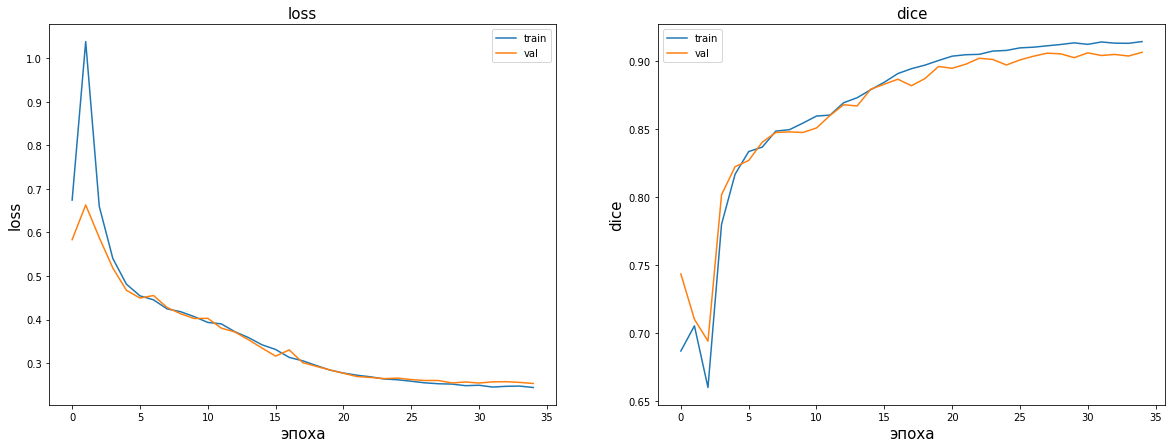

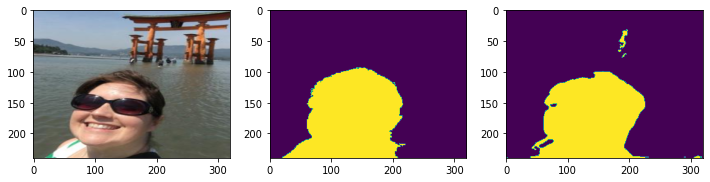

In [ ]:
model, history = train_with_aug(model,
                                criterion,
                                optimizer,
                                scheduler,
                                train_batch_gen,
                                val_batch_gen,
                                model_num=1,
                                num_epochs=50)

In [30]:
history["dice"]["val"]

[0.7433712248704576,
 0.7099833110622135,
 0.6938775688059154,
 0.8017767227407164,
 0.8224251966796264,
 0.8269643867590241,
 0.840476724666735,
 0.8476332945246402,
 0.8480421816075987,
 0.8476349274683851,
 0.8509335035800721,
 0.8601783997708615,
 0.868044767742644,
 0.8671874675069091,
 0.8795137657202754,
 0.8831957570947209,
 0.8868532032102646,
 0.8820823316940318,
 0.8873509508812528,
 0.8962678845648041,
 0.8949096561926898,
 0.8979156031451138,
 0.9023019261613069,
 0.9014127196893954,
 0.897348466180797,
 0.9010674480042544,
 0.9038295675557239,
 0.9060385595082413,
 0.9055873857802602,
 0.902740062205427,
 0.9063008460423427,
 0.9043532980677944,
 0.9051089794479364,
 0.9039516565868064,
 0.9066658994378586,
 0.9057393013379483,
 0.9055515451916656,
 0.9060634022669078,
 0.9051851282140456,
 0.9077983404763335,
 0.903204706607153,
 0.9062167095233274,
 0.9066424211727601,
 0.9066322004979731,
 0.9060559486175256,
 0.906131368209163,
 0.9053505310319112,
 0.9061090936693191